# BikeNow XGBoost Regression

Import libraries.

In [4]:
%%time

import os
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()
region = boto3.Session().region_name

bucket='bike-demo-stack-applicationdatal-s3bucketdatalake-dncpxowjgqbf' # put your s3 bucket name here, and create s3 bucket
src_file = 'unload/station_status_history_000'
prefix = 'sagemaker/bikenow-xgboost-regression'

# customize to your bucket where you have stored the data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket)

print(bucket_path)

https://s3-us-east-1.amazonaws.com/bike-demo-stack-applicationdatal-s3bucketdatalake-dncpxowjgqbf
CPU times: user 595 ms, sys: 43.4 ms, total: 639 ms
Wall time: 658 ms


Helper functions to split data into training, validation, and testing sets.

In [5]:
%%time

import io
import boto3
import random

def data_split(FILE_DATA, FILE_TRAIN, FILE_VALIDATION, FILE_TEST, PERCENT_TRAIN, PERCENT_VALIDATION, PERCENT_TEST):
    data = [l for l in open(FILE_DATA, 'r')]
    train_file = open(FILE_TRAIN, 'w')
    valid_file = open(FILE_VALIDATION, 'w')
    tests_file = open(FILE_TEST, 'w')

    num_of_data = len(data)
    num_train = int((PERCENT_TRAIN/100.0)*num_of_data)
    num_valid = int((PERCENT_VALIDATION/100.0)*num_of_data)
    num_tests = int((PERCENT_TEST/100.0)*num_of_data)

    data_fractions = [num_train, num_valid, num_tests]
    split_data = [[],[],[]]

    rand_data_ind = 0

    for split_ind, fraction in enumerate(data_fractions):
        for i in range(fraction):
            rand_data_ind = random.randint(0, len(data)-1)
            split_data[split_ind].append(data[rand_data_ind])
            data.pop(rand_data_ind)

    for l in split_data[0]:
        train_file.write(l)

    for l in split_data[1]:
        valid_file.write(l)

    for l in split_data[2]:
        tests_file.write(l)

    train_file.close()
    valid_file.close()
    tests_file.close()

def write_to_s3(fobj, bucket, key):
    return boto3.Session(region_name=region).resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def upload_to_s3(bucket, channel, filename):
    fobj=open(filename, 'rb')
    key = prefix+'/'+channel
    url = 's3://{}/{}/{}'.format(bucket, key, filename)
    print('Writing to {}'.format(url))
    write_to_s3(fobj, bucket, key)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 294 µs


Download data and split files.

In [7]:
%%time
import urllib.request

# Load the dataset
FILE_DATA = 'bikenow'
boto3.Session(region_name=region).resource('s3').Bucket(bucket).Object(src_file).download_file(FILE_DATA)
#urllib.request.urlretrieve("https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression/abalone", FILE_DATA)

#split the downloaded data into train/test/validation files
FILE_TRAIN = 'bikenow.train'
FILE_VALIDATION = 'bikenow.validation'
FILE_TEST = 'bikenow.test'
PERCENT_TRAIN = 70
PERCENT_VALIDATION = 15
PERCENT_TEST = 15
data_split(FILE_DATA, FILE_TRAIN, FILE_VALIDATION, FILE_TEST, PERCENT_TRAIN, PERCENT_VALIDATION, PERCENT_TEST)

#upload the files to the S3 bucket
upload_to_s3(bucket, 'train', FILE_TRAIN)
upload_to_s3(bucket, 'validation', FILE_VALIDATION)
upload_to_s3(bucket, 'test', FILE_TEST)

Writing to s3://bike-demo-stack-applicationdatal-s3bucketdatalake-dncpxowjgqbf/sagemaker/bikenow-xgboost-regression/train/bikenow.train
Writing to s3://bike-demo-stack-applicationdatal-s3bucketdatalake-dncpxowjgqbf/sagemaker/bikenow-xgboost-regression/validation/bikenow.validation
Writing to s3://bike-demo-stack-applicationdatal-s3bucketdatalake-dncpxowjgqbf/sagemaker/bikenow-xgboost-regression/test/bikenow.test
CPU times: user 4.52 s, sys: 20.5 ms, total: 4.54 s
Wall time: 5.08 s


Get XGBoost container image.

In [8]:
%%time
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(region, 'xgboost', '0.90-1')

CPU times: user 27 µs, sys: 1 µs, total: 28 µs
Wall time: 30.3 µs


Create training job.

In [10]:
%%time
import boto3
from time import gmtime, strftime

job_name = 'bikenow-xgboost-regression-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job", job_name)

#Ensure that the training and validation data folders generated above are reflected in the "InputDataConfig" parameter below.

create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": bucket_path + "/" + prefix + "/single-xgboost"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.m4.4xlarge",
        "VolumeSizeInGB": 5
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "silent":"0",
        "objective":"reg:linear",
        "num_round":"50"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 3600
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/" + prefix + '/train',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/" + prefix + '/validation',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None"
        }
    ]
}


client = boto3.client('sagemaker', region_name=region)
client.create_training_job(**create_training_params)

import time

status = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)
while status !='Completed' and status!='Failed':
    time.sleep(60)
    status = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print(status)

Training job bikenow-xgboost-regression-2019-12-19-02-00-00
InProgress
InProgress
InProgress
InProgress
Completed
CPU times: user 70.7 ms, sys: 546 µs, total: 71.3 ms
Wall time: 4min


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


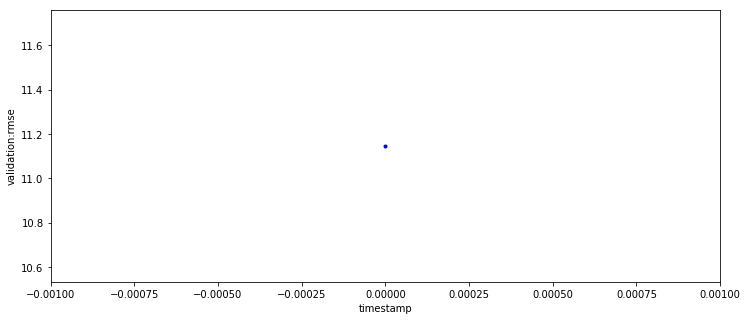

In [11]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

metric_name = 'validation:rmse'

metrics_dataframe = TrainingJobAnalytics(training_job_name=job_name, metric_names=[metric_name]).dataframe()
plt = metrics_dataframe.plot(kind='line', figsize=(12,5), x='timestamp', y='value', style='b.', legend=False)
plt.set_ylabel(metric_name);

In [12]:
%%time
import boto3
from time import gmtime, strftime

model_name=job_name + '-model'
print(model_name)

info = client.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

bikenow-xgboost-regression-2019-12-19-02-00-00-model
https://s3-us-east-1.amazonaws.com/bike-demo-stack-applicationdatal-s3bucketdatalake-dncpxowjgqbf/sagemaker/bikenow-xgboost-regression/single-xgboost/bikenow-xgboost-regression-2019-12-19-02-00-00/output/model.tar.gz
arn:aws:sagemaker:us-east-1:699772153487:model/bikenow-xgboost-regression-2019-12-19-02-00-00-model
CPU times: user 15.7 ms, sys: 238 µs, total: 15.9 ms
Wall time: 277 ms


In [13]:
from time import gmtime, strftime

endpoint_config_name = 'bikenow-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

bikenow-XGBoostEndpointConfig-2019-12-19-02-06-19
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:699772153487:endpoint-config/bikenow-xgboostendpointconfig-2019-12-19-02-06-19


In [14]:
%%time
import time

endpoint_name = 'bikenow-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

bikenow-XGBoostEndpoint-2019-12-19-02-06-37
arn:aws:sagemaker:us-east-1:699772153487:endpoint/bikenow-xgboostendpoint-2019-12-19-02-06-37
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:699772153487:endpoint/bikenow-xgboostendpoint-2019-12-19-02-06-37
Status: InService
CPU times: user 127 ms, sys: 12.5 ms, total: 140 ms
Wall time: 10min 1s


In [15]:
runtime_client = boto3.client('runtime.sagemaker', region_name=region)

In [16]:
!head -1 bikenow.test > bikenow.single.test

In [26]:
%%time
import json
from itertools import islice
import math
import struct

file_name = 'bikenow.single.test' #customize to your test file
with open(file_name, 'r') as f:
    payload = f.read().strip().split(',', 1)
response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/csv', 
                                   Body=payload[1])
result = response['Body'].read()
result = result.decode("utf-8")
result = result.split(',')
result = [round(float(i)) for i in result]
label = payload[0]
print ('Label: ',label,'\nPrediction: ', result[0])

Label:  5 
Prediction:  13
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 24.4 ms


In [27]:
import sys
import math
def do_predict(data, endpoint_name, content_type):
    payload = '\n'.join(data)
    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType=content_type, 
                                   Body=payload)
    result = response['Body'].read()
    result = result.decode("utf-8")
    result = result.split(',')
    preds = [float((num)) for num in result]
    preds = [round(num) for num in preds]
    return preds

def batch_predict(data, batch_size, endpoint_name, content_type):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)], endpoint_name, content_type)
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items], endpoint_name, content_type))
        sys.stdout.write('.')
    return(arrs)

In [36]:
%%time
import json
import numpy as np

with open(FILE_TEST, 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(',', 1)[0]) for line in payload.split('\n')]
test_data = [line.split(',', 1)[1] for line in payload.split('\n')]
preds = batch_predict(test_data, 100, endpoint_name, 'text/csv')

print('\n Mean Squared Error = ', np.mean((np.array(labels) - np.array(preds))**2))

................................................................................................................................................................................................................................................................................................................................................................................
 Mean Squared Error =  79.96900764605044
CPU times: user 665 ms, sys: 65 ms, total: 730 ms
Wall time: 3.89 s
